In [1]:
#import dependents
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
pd.options.display.float_format = '{:,.3f}'.format
pd.get_option("display.max_columns")
import warnings
warnings.filterwarnings('ignore')

In [2]:
def cleanDF(df):
    df = df.drop(df[(df.year == 2020) & (df.quarter == 2)].index)
    df = df.drop(df[(df.year == 2020) & (df.quarter == 3)].index)
    df.index = range(0,len(df))
    #creat Vs
    df.rename(columns = {'Duration of job vacancy, all durations': 'all'}, inplace = True)
    df.rename(columns = {'Less than 15 days': 'a000b014'}, inplace = True)
    df.rename(columns = {'15 to 29 days': 'a015b029'}, inplace = True)
    df.rename(columns = {'30 to 59 days': 'a030b059'}, inplace = True)
    df.rename(columns = {'60 to 89 days': 'a060b089'}, inplace = True)
    df.rename(columns = {'90 days or more': 'a090binf'}, inplace = True)
    df.rename(columns = {'90 to 119 days': 'a090b119'}, inplace = True)
    df.rename(columns = {'120 days or more': 'a120binf'}, inplace = True)
    df['a000binf'] = df['a000b014'] + df['a015b029'] + df['a030b059'] + df['a060b089'] + df['a090binf']
    #rearrage columns:
    df = df[['t', 'year', 'quarter', 'all',
             'a000binf', 'a000b014', 'a015b029', 'a030b059', 'a060b089', 'a090binf', 'a090b119', 'a120binf']]
    return df

In [3]:
df_all = cleanDF(pd.read_csv('data/all.csv'))
#by occupation type
df_cultur = cleanDF(pd.read_csv('data/art culture recreation and sport.csv'))
df_buzfin = cleanDF(pd.read_csv('data/Business finance and administration.csv'))
df_social = cleanDF(pd.read_csv('data/education law and social community and government services.csv'))
df_health = cleanDF(pd.read_csv('data/Health.csv'))
df_manage = cleanDF(pd.read_csv('data/management.csv'))
df_manufa = cleanDF(pd.read_csv('data/manufacturing and utilities.csv'))
df_engine = cleanDF(pd.read_csv('data/Natural and applied sciences and related.csv'))
df_agricu = cleanDF(pd.read_csv('data/Natural resources agriculture and related production.csv'))
df_servic = cleanDF(pd.read_csv('data/Sales and service.csv'))
df_trades = cleanDF(pd.read_csv('data/Trades transport and equipment operators and related.csv'))
df_0class = cleanDF(pd.read_csv('data/Unclassified.csv'))
#by province
df_ON = cleanDF(pd.read_csv('data/pov_ON.csv'))
df_QC = cleanDF(pd.read_csv('data/pov_QC.csv'))
df_BC = cleanDF(pd.read_csv('data/pov_BC.csv'))
df_AB = cleanDF(pd.read_csv('data/pov_AB.csv'))
df_MB = cleanDF(pd.read_csv('data/pov_MB.csv'))
df_SK = cleanDF(pd.read_csv('data/pov_SK.csv'))

Employing the steady-state assumption, we can model job vacancies over time as:
$$
v(t)=V_0q^t
$$
where $V_0$ is the inflow of new job vacancies created at $t=0$, and $q$ is the probability of a vacancy being filled during period $t$. The geometric series of the model would be:
$$
V_{a,b}=\sum_{t=a}^{b}v(t) \\
V_{a,b}={V_0q^a(1-q^b)\over1-q}
$$

In [4]:
def genDF0(df, df0, quarter):
    df0 = df0.append({'V':df.loc[quarter,'a000binf'],'a':float(0),'b':np.inf,'id':'a000binf'},ignore_index=True)
    df0 = df0.append({'V':df.loc[quarter,'a000b014'],'a':float(0),'b':float(14), 'id':'a000b014'},ignore_index=True)
    df0 = df0.append({'V':df.loc[quarter,'a015b029'],'a':float(15),'b':float(29),'id':'a015b029'},ignore_index=True)
    df0 = df0.append({'V':df.loc[quarter,'a030b059'],'a':float(30),'b':float(59),'id':'a030b059'},ignore_index=True)
    df0 = df0.append({'V':df.loc[quarter,'a060b089'],'a':float(60),'b':float(89),'id':'a060b089'},ignore_index=True)
    df0 = df0.append({'V':df.loc[quarter,'a090binf'],'a':float(90),'b':np.inf,'id':'a090binf'},ignore_index=True)
    df0 = df0.append({'V':df.loc[quarter,'a090b119'],'a':float(90),'b':float(119),'id':'a090b119'},ignore_index=True)
    df0 = df0.append({'V':df.loc[quarter,'a120binf'],'a':float(120),'b':np.inf,'id':'a120binf'},ignore_index=True)
    df0 = df0[df0['V'].notna()]
    df0['V'] = df0['V'].astype(float, errors='ignore')
    return df0

coeffs0 = [10000, 0.5] #initial guess
def fitting(df0, coeffs0):
    #fitting    v0 = coeffs[0] = , q = 1 - coeffs[1]
    a = df0['a'].to_numpy()
    b = df0['b'].to_numpy()
    v = df0['V'].to_numpy()
    def model(coeffs, a , b):
        zeroInf = coeffs[0] / (1 - coeffs[1])
        adj = (coeffs[1] ** a) * (1 - (coeffs[1] ** b))
        return zeroInf * adj
    def residual(coeffs):
        return model(coeffs, a , b) - v 
    fit = least_squares(residual, coeffs0)
    return fit

In [5]:
def NLS(df):
    df0 = pd.DataFrame()
    for quarter in range(len(df)):
        df0 = genDF0(df, df0, quarter)
    #fitting    v0 = coeffs[0] = , q = 1 - coeffs[1]
    fit = fitting(df0, coeffs0) 
    #record
    v0 = fit.x[0]
    q = 1 - fit.x[1]
    return v0 , q

def NLS_quarterly(df):
    for quarter in range(len(df)):
        df0 = pd.DataFrame()
        df0 = genDF0(df, df0, quarter)
        #fitting    v0 = coeffs[0] = , q = 1 - coeffs[1]
        fit = fitting(df0, coeffs0) 
        #record
        v0 = fit.x[0]
        q = 1- fit.x[1]
        if q != coeffs0[1]:
            df.loc[quarter, 'v0'] = v0
            df.loc[quarter, 'q'] = q
        else:
            pass
        idList = df0['id'].tolist()
        for i in range(len(fit.fun)):
            df.loc[quarter, f'ε_{idList[i]}'] = fit.fun[i]
        df0 = df0.iloc[0:0] #clear df0
    return df

In [6]:
#fitting
fit_all = NLS(df_all)
df_all = NLS_quarterly(df_all)
#print(fit_all)
#display(df_all)

In [7]:
#fitting: Province
POV_list = ['ON', 'QC', 'BC', 'AB', 'MB', 'SK']
for i in POV_list:
    df = globals()[f'df_{i}']
    globals()[f'fit_{i}'] = NLS(df)
POV_result = pd.DataFrame()
POV_result = POV_result.append({'POV': 'All', 'v0': fit_all[0], 'q':fit_all[1]}, ignore_index=True)
for j in POV_list:
    fit = globals()[f'fit_{j}']
    POV_result = POV_result.append({'POV': j, 'v0': fit[0], 'q':fit[1]}, ignore_index=True)
POV_result = POV_result.replace({'ON': 'Ontario', 'QC': 'Quebec', 'BC': 'British Columbia',
                                 'AB': 'Alberta', 'MB': 'Manitoba', 'SK': 'Saskatchewan'})

In [8]:
#fitting: Occupation
NOC_list = ['cultur', 'buzfin', 'social', 'health', 'manage', 'manufa', 
            'engine', 'agricu', 'servic', 'trades', '0class']
for i in NOC_list:
    df = globals()[f'df_{i}']
    globals()[f'fit_{i}'] = NLS(df)
NOC_result = pd.DataFrame()
NOC_result = NOC_result.append({'NOC': 'All', 'v0': fit_all[0], 'q':fit_all[1]}, ignore_index=True)
for j in NOC_list:
    fit = globals()[f'fit_{j}']
    NOC_result = NOC_result.append({'NOC': j, 'v0': fit[0], 'q':fit[1]}, ignore_index=True)
NOC_result = NOC_result.replace({'cultur': 'Art culture recreation and sport',
                                 'buzfin': 'Business finance and administration',
                                 'social': 'Education law and social community and government services',
                                 'health': 'Health',
                                 'manage': 'Management',
                                 'manufa': 'Manufacturing and utilities',
                                 'engine': 'Natural and applied sciences and related',
                                 'agricu': 'Natural resources agriculture and related production',
                                 'servic': 'Sales and service',
                                 'trades': 'Trades transport and equipment operators and related',
                                 '0class': 'Unclassified'})

In [9]:
#quarterly fitting
#POV
for i in POV_list:
    df = globals()[f'df_{i}']
    globals()[f'df_{i}'] = NLS_quarterly(df)
#NOC
for i in NOC_list:
    df = globals()[f'df_{i}']
    globals()[f'df_{i}'] = NLS_quarterly(df)

In [10]:
display(POV_result)
display(NOC_result)

,POV,q,v0
0,All,0.020,"8,442.220"
1,Ontario,0.025,"4,045.769"
2,Quebec,0.010,946.786
3,British Columbia,0.017,"1,246.234"
4,Alberta,0.034,"1,515.699"
5,Manitoba,0.023,286.568
6,Saskatchewan,0.035,334.442


,NOC,q,v0
0,All,0.020,"8,442.220"
1,Art culture recreation and sport,0.029,273.157
2,Business finance and administration,0.032,"1,627.013"
3,Education law and social community and governm...,0.019,498.786
4,Health,0.006,194.507
5,Management,0.021,506.157
6,Manufacturing and utilities,0.010,217.451
7,Natural and applied sciences and related,0.017,548.465
8,Natural resources agriculture and related prod...,0.018,252.439
9,Sales and service,0.030,"4,286.621"


In [11]:
def plot(df, year, quarter):
    plt.rcParams["figure.figsize"] = [10, 6]
    year = int(year)
    quarter = int(quarter)
    df = df[(df['year'] == year) & (df['quarter'] == quarter)]
    df.index = range(0,len(df))
    index = ['day 0-∞','day 00-14','day 15-29','day 30-59','day 60-89','day 90-∞','day 90 - 119','day 120-∞']
    obs = df[['a000binf','a000b014','a015b029','a030b059','a060b089','a090binf','a090b119','a120binf']].T
    obs['Time Interval'] = index
    obs.rename(columns = {0: 'observation'}, inplace = True)
    obs = obs.set_index('Time Interval')
    res = df[['ε_a000binf','ε_a000b014','ε_a015b029','ε_a030b059',
              'ε_a060b089','ε_a090binf','ε_a090b119','ε_a120binf']].T
    res['Time Interval'] = index
    res.rename(columns = {0: 'residual'}, inplace = True)
    res = res.set_index('Time Interval')
    df0 = pd.concat([obs, res], axis=1)    
    df0['model est.'] = df0['observation'] + df0['residual']
    #display and plot
    v0 = df.loc[0, 'v0']
    q = df.loc[0, 'q']
    df0 = df0[['observation', 'model est.', 'residual']]
    display(df0)
    print(f'V0={v0}, q={q}')
    df0.plot(kind="bar")
    plt.xticks(rotation=30, horizontalalignment="center")
    plt.xlabel("Time Interval")
    plt.ylabel("Job Vacancies")
    plt.title(f"Observation, Estimation, and Residual - {year} Q{quarter}")
    plt.show()

,observation,model est.,residual
Time Interval,,,
day 0-∞,"890,385.000","771,366.283","-119,018.717"
day 00-14,"173,840.000","95,942.141","-77,897.859"
day 15-29,"149,430.000","160,924.646","11,494.646"
day 30-59,"156,055.000","248,744.761","92,689.761"
day 60-89,"90,075.000","248,914.118","158,839.118"
day 90-∞,"320,985.000","328,423.691","7,438.691"
day 90 - 119,"51,250.000","222,224.827","170,974.827"
day 120-∞,"269,740.000","247,073.264","-22,666.736"


V0=7283.59341624579, q=0.009442457596793408


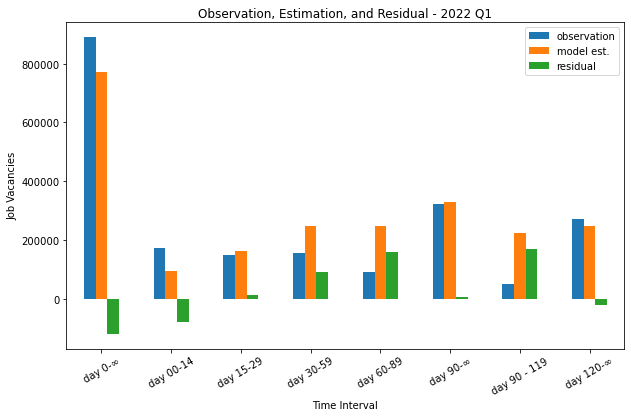

In [12]:
plot(df_all, 2022, 1)

<AxesSubplot:>

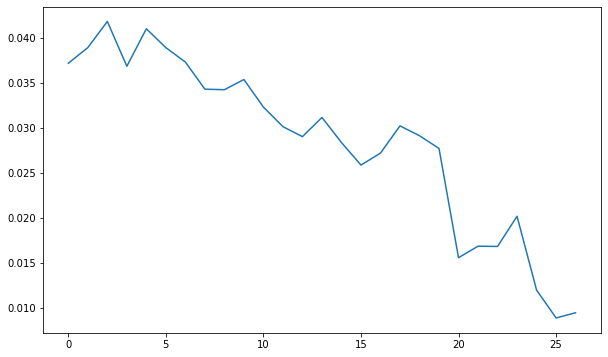

In [13]:
df_all['q'].plot.line()

In [14]:
df_all

,t,year,quarter,all,a000binf,a000b014,a015b029,a030b059,a060b089,a090binf,...,v0,q,ε_a000binf,ε_a000b014,ε_a015b029,ε_a030b059,ε_a060b089,ε_a090binf,ε_a090b119,ε_a120binf
0,1,2015,1,"408,125.000","325,995.000","113,260.000","83,630.000","64,160.000","25,115.000","39,830.000",...,"11,279.201",0.037,"-22,546.561","11,630.552","30,976.120","22,819.882","5,076.174","-29,794.312",NaN,NaN
1,2,2015,2,"451,925.000","358,550.000","126,345.000","102,280.000","68,450.000","22,310.000","39,165.000",...,"13,065.178",0.039,"-22,740.301","16,795.527","24,308.754","23,835.842","7,829.684","-29,724.368",NaN,NaN
2,3,2015,3,"407,865.000","321,060.000","121,925.000","87,780.000","58,290.000","21,275.000","31,790.000",...,"12,595.730",0.042,"-19,809.332","13,656.519","24,960.903","18,627.550","1,432.694","-25,340.655",NaN,NaN
3,4,2015,4,"358,755.000","281,500.000","96,690.000","75,190.000","57,310.000","21,110.000","31,200.000",...,"9,681.094",0.037,"-18,670.972","10,725.740","24,088.394","18,629.573","5,562.870","-22,230.492",NaN,NaN
4,5,2016,1,"330,215.000","265,055.000","98,600.000","71,795.000","48,650.000","16,660.000","29,350.000",...,"10,172.906",0.041,"-16,936.326","11,442.441","21,294.522","16,039.455","2,981.785","-23,617.718",NaN,NaN
5,6,2016,2,"391,190.000","319,630.000","113,035.000","87,695.000","59,525.000","21,595.000","37,780.000",...,"11,609.272",0.039,"-21,206.605","14,158.261","24,801.226","22,495.557","5,196.334","-29,386.891",NaN,NaN
6,7,2016,3,"404,860.000","324,110.000","111,330.000","89,330.000","64,380.000","23,200.000","35,870.000",...,"11,297.649",0.037,"-21,243.031","13,663.697","25,048.020","22,159.771","6,698.861","-25,976.634",NaN,NaN
7,8,2016,4,"381,010.000","306,840.000","99,275.000","80,880.000","64,735.000","24,525.000","37,425.000",...,"9,789.742",0.034,"-21,319.604","11,055.954","26,792.712","22,715.928","9,094.986","-25,066.966",NaN,NaN
8,9,2017,1,"387,080.000","313,645.000","100,235.000","82,725.000","62,370.000","24,125.000","44,190.000",...,"9,953.573",0.034,"-22,840.265","11,983.498","26,929.716","26,817.028","10,235.518","-31,533.050",NaN,NaN
9,10,2017,2,"459,685.000","376,445.000","123,895.000","99,145.000","76,490.000","25,875.000","51,040.000",...,"12,371.565",0.035,"-26,592.393","14,616.074","32,957.998","28,108.552","12,828.064","-37,341.622",NaN,NaN
